# Computational Neuroscience: Sheet 2 - Single two-state channel

This code (in Python 3.6.15) should provide the answers to the problem set. Note, there are often different ways to obtain the solutions, here are simply my solutions.

## Imports and defining plotting functions

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Plotting Functions
'''Plotting the stochastic dynamics of the channel. 
    'n_first_time_steps' can be changed to plot just the first 'n' steps of the simulation.'''
def plot_channel_simulation(t, x, n_first_time_steps = None):
    fig = plt.figure(figsize=(16,6))
    plt.step(t[:n_first_time_steps], x[:n_first_time_steps])
    plt.title('Single channel simulation')
    plt.xlabel('Time (s)')
    #plt.xlim((0, 300)) # zoom in time
    plt.ylabel('State of the channel X')
    plt.yticks([0, 1], ['Closed', 'Open'])
    plt.show()
    return

'''Plotting the histogram of channel state dwell time. 'binss' changes the number of bins used in the histogram. '''
def hist_dwell_times(dwell_times, binss = 20, densityy = True, curve = None, title = ''):
    fig = plt.figure(figsize=(16,6))
    plt.plot(curve[0], curve[1]) if curve != None else None
    plt.hist(dwell_times, bins = binss, density = densityy)
    plt.title('Dwell times distribution ' + title)
    plt.ylabel('Density')
    plt.xlabel('Time (s)')
    plt.show()
    
'''Plotting the histogram of channel state dwell time. 'binss' changes the number of bins used in the histogram. '''
def hist_dwell_times2(dwell_times, binss = 20, densityy = True, curve = None, title = ''):
    fig, ax = plt.subplots(ncols=2, figsize=(16,6))

    ax[0].plot(curve[0][0], curve[0][1]) if curve != None else None
    ax[0].hist(dwell_times[0], bins = binss, density = densityy)
    ax[0].set_title('Dwell times distribution for the closed state')
    ax[0].set_ylabel('Density')
    ax[0].set_xlabel('Time (s)')
    
    ax[1].hist(dwell_times[1], bins = binss, density = densityy)
    ax[1].plot(curve[1][0], curve[1][1]) if curve != None else None
    ax[1].set_title('Dwell times distribution for the open state')
    ax[1].set_ylabel('Density')
    ax[1].set_xlabel('Time (s)')
    
    plt.show()

'''Plotting propagation of channel state probabilities. 'n_first_time_steps' has the same usage as above.'''
def plot_channel_probabilities(time, states, n_first_time_steps = None):
    fig = plt.figure(figsize=(16,6))
    plt.plot(time[:n_first_time_steps], states[:n_first_time_steps,0], label='Pr(closed)')
    plt.plot(time[:n_first_time_steps], states[:n_first_time_steps,1], label='Pr(open)')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('State probabilities')
    plt.show()

## Defining parameters

In [2]:
# Temporal parameters
T = 500   # total time of simulation
dt = 0.1   # timestep of the simulation

# Transition parameters and left stochastic matrix which you should have obtained in Problem 1
alpha = 0.1
beta = 0.2

#The left stochastic Matrix
A = np.array([[1 - alpha*dt, beta*dt],
              [alpha*dt,     1 - beta*dt]])

# Initial state: here starting as closed (1,0)
x0 = np.array([[0, 1]])

## Problem 2: Simulation of a single channel

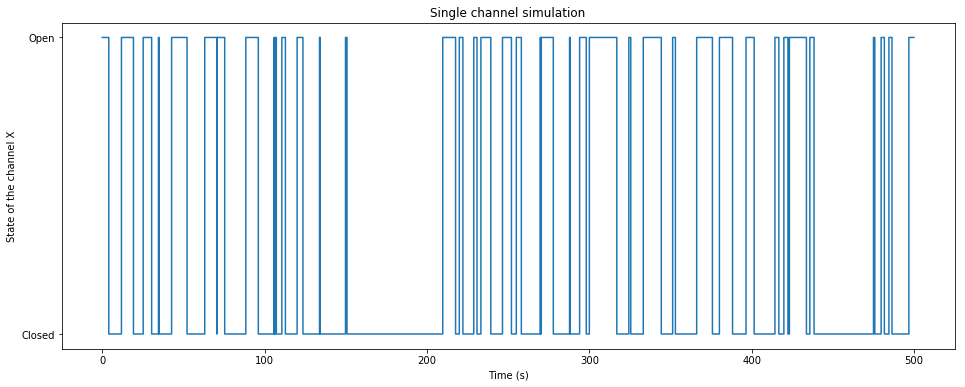

Mean state: 0.3456


In [3]:
#Defining a function which simulates the dynamics of the channel
def channel_sim(A, x0, dt, T):
    # Initialize variables
    t = np.arange(0, T, dt)  #all time-steps of the simulation
    random_x = x0            #random_x will keep track of our channel's state over time. Initial state is x0

    #For loop choosing the new state at timestep 'i' by multiplying the stochastic matrix with the state at step 'i-1'.
        #Random_x is then appended during each step with the new state.
    for i in np.arange(len(t)-1):
        random_x_i = [0,1] if np.random.choice(2, 1, p = np.dot(A, random_x[i])) == 1 else [1,0]
        random_x = np.vstack((random_x, random_x_i))
        
    return random_x, t

#Performing the simulation
random_x, t = channel_sim(A, x0, dt, T)

#Plotting the dynamics. random_x[:,1] is 0 when closed and 1 when open and so the same as X in the problem sheet
plot_channel_simulation(t, random_x[:,1])    

# Calculating the mean state during the whole simulation, last 400s, and the number of open and closed time steps
mean_state = np.mean(random_x[:,1])

print('Mean state:', mean_state)

## Problem 3: Channel dwell times

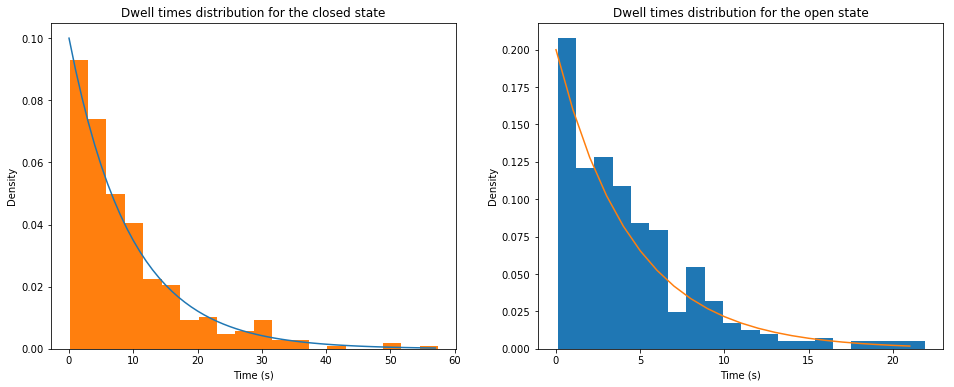

Mean closed state dwell time is: 9.045. The expected mean is: 10.0.
Mean open state dwell time is: 4.398. The expected mean is: 5.0.


In [4]:
#First, simulation channel dynamics for longer: T = 5000s (this may take a while, start with 1000s and increase)
T = 5000
random_x, t = channel_sim(A, x0, dt, T)

#Vector determining when transitions are made: -1 channel closes, +1 channel opens, 0 no transition
state_diff = np.diff(list(random_x[:,1]))

#Finding indices (i.e. time steps) for the respective transitions
o_transitions = [i for i, e in enumerate(list(state_diff)) if e == 1]
c_transitions = [i for i, e in enumerate(list(state_diff)) if e == -1]

#Calculating dwell times as time-difference: 
#open dwell-times as time difference between open and the next closing transitions, vice-versa for closed dwell-times
if x0[0,1] == 0: #if channel initially closed, don't include the initial closed period of the channel
    o_dwell_times = [c_transitions - o_transitions for c_transitions, o_transitions in zip(c_transitions, o_transitions)]
    c_dwell_times = [o_transitions - c_transitions for c_transitions, o_transitions in zip(c_transitions, o_transitions[1:])]
else: #when the initial state of the channel is open
    o_dwell_times = [c_transitions - o_transitions for c_transitions, o_transitions in zip(c_transitions[1:], o_transitions)]
    c_dwell_times = [o_transitions - c_transitions for c_transitions, o_transitions in zip(c_transitions, o_transitions)]

# #Multiplying lists by 'dt' time convert units from time-steps to seconds
o_dwell_times = np.array(o_dwell_times) * dt
c_dwell_times = np.array(c_dwell_times) * dt

#First getting the theoretical curve expectation, which are geometric distributions (look at wikipedia entry)
#We can decide to just work in steps of seconds (use alpha instead of alpha * dt), since then the conversion steps to
    #time is just 1 to 1 and we don't need to renormalise the distribution.
#So, the distribution for the closed state, where the exponent is x1 = 0, 1, 2, ..., or x1-1 for x1 = 1, 2, 3, ...
x1 = np.arange(0, max(c_dwell_times), 1)
y1 = (1 - alpha)**(x1) * alpha  #geometric distribution f(t_i) = (1 - alpha)^(t_i - 1) * alpha

#Doing the same for the open state
x2 = np.arange(0, max(o_dwell_times), 1) 
y2 = (1 - beta)**(x2) * beta  #geometric distribution f(t_i) = (1 - beta)^(t_i - 1) * beta

#Plotting both histograms with the curves, with x tics given by x1 * dt to plot against time and not steps
hist_dwell_times2([c_dwell_times, o_dwell_times], curve = [[x1, y1], [x2, y2]])

#Printing the means calculated from the data and from theory
print('Mean closed state dwell time is: ' + str(round(np.mean(c_dwell_times), 3)) + '. The expected mean is: ' + \
      str(1 / alpha) + '.')
print('Mean open state dwell time is: ' + str(round(np.mean(o_dwell_times), 3)) + '. The expected mean is: ' + \
      str(1 / beta)+ '.')

# Problem 4: Propagation of state probabilities

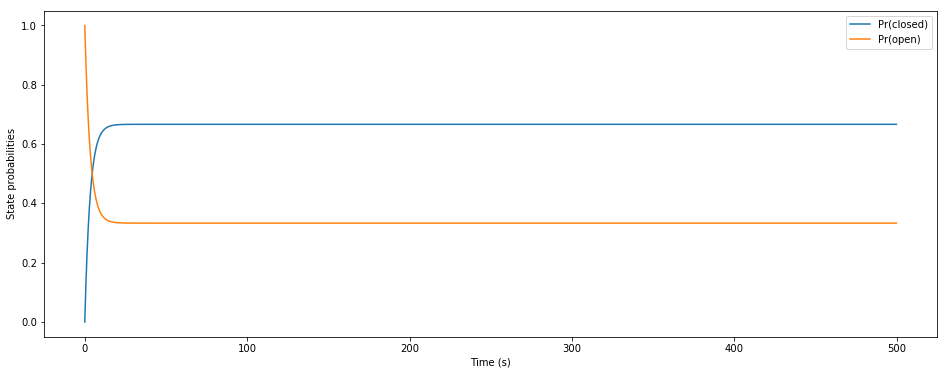

Equilibrium state is: 0.667. Expected from differential eqn: 0.667. Expected from stochastic matrix : 0.667.
Time constant is: 3.3182. Expected from the differential eqn: 3.3333.


In [5]:
#First defining a function to propagate the probabilities:
def probability_prop(A, x0, dt, T):
    # Initialize variables
    t = np.arange(0, T, dt)
    x = x0  #initiate x which will keep track of states over time, x0 being the initial state

    # For loop to proapgate the probabilities at each time step, which is just x_i+1 = A.x_i
    for i in range(len(t)-1):
        x_i = np.dot(A, x[-1,:]) #compute the state of x at time i+1
        x = np.vstack((x, x_i))  #append this new state onto x

    return x, t

#Simulating the propagation, using parameters already defined previously, though changing T if needed
T = 500
x, t = probability_prop(A, x0, dt, T)

#Plotting
plot_channel_probabilities(t, x)

#Printing the equilibrium state (state at the end of the simulation) against theoretical expectation
#Expectation from differential equation (how x_inf is defined, see lecture)
expected_eq = beta / (alpha + beta)

#Expectation from stochastic matrix
evals, evecs = np.linalg.eig(A) #obtaining eigensystem
ind = list(evals).index(1)      #obtaining index of eigenvalue equal to 1 (for which we need the eigenvector)
expected_eq2 = (evecs[:,ind] / np.sum(evecs[:,ind]))[0]
print('Equilibrium state is: ' + str(round(x[-1,0], 3)) + '. Expected from differential eqn: '+ \
      str(round(expected_eq, 3)) + '. Expected from stochastic matrix : ' + str(round(expected_eq2, 3)) + '.')

#For the time-constant tau we need to do a bit more calculation
#First calculating the half-life of the decaying probability, by finding value closest to half the starting value,
    #then finding the index of that value and multiplying by dt to change units to seconds    
if x0[0,0] == 1: #if channel started closed, then decaying probability is that of x[:,0]
    half_val = (1 - x[-1,0]) / 2 + x[-1,0]
    closest_half_val = min(list(x[:,0]), key=lambda x1:abs(x1 - half_val))
    index_of_chv = list(x[:,0]).index(closest_half_val)
    half_life = index_of_chv * dt
else:            #if channel started open, then decaying probability is that of x[:,1]
    half_val = (1 - x[-1,1]) / 2 + x[-1,1]
    closest_half_val = min(list(x[:,1]), key=lambda x1:abs(x1 - half_val))
    index_of_chv = list(x[:,1]).index(closest_half_val)
    half_life = index_of_chv * dt 

#Calculating the time-constant from the half-life
time_constant = half_life / np.log(2)

#Calculating the expected time-constant from theory
expected_time_constant = 1 / (alpha + beta)

print('Time constant is: ' + str(round(time_constant, 4)) + '. Expected from the differential eqn: ' + \
      str(round(expected_time_constant, 4)) + '.')